In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cmdstanpy

C:\Users\yongd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
url = "https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/drp_scores.csv"
# Treatment and response data for a study on the effect of a treatment
data_str = """
Treatment	Response
Treated	24
Treated	43
Treated	58
Treated	71
Treated	43
Treated	49
Treated	61
Treated	44
Treated	67
Treated	49
Treated	53
Treated	56
Treated	59
Treated	52
Treated	62
Treated	54
Treated	57
Treated	33
Treated	46
Treated	43
Treated	57
Control	42
Control	43
Control	55
Control	26
Control	62
Control	37
Control	33
Control	41
Control	19
Control	54
Control	20
Control	85
Control	46
Control	10
Control	17
Control	60
Control	53
Control	42
Control	37
Control	42
Control	55
Control	28
Control	48
"""

In [9]:
from io import StringIO

data = StringIO(data_str)
df = pd.read_csv(data, sep="\t")
df.head(3)

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58


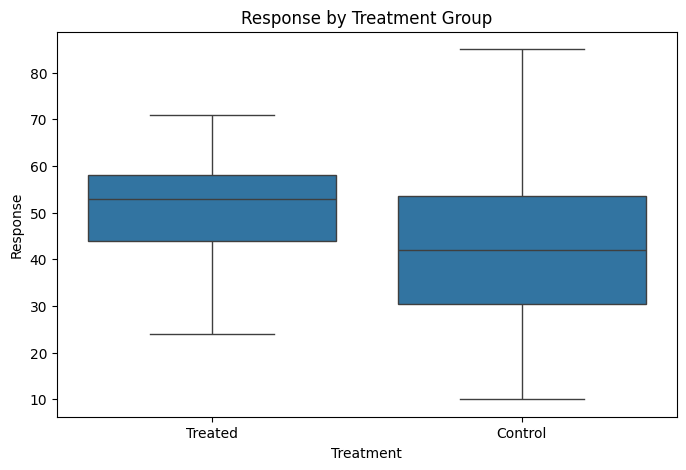

In [22]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Treatment", y="Response", data=df)
plt.title("Response by Treatment Group")
plt.show()

In [16]:
grouped = df.groupby("Treatment")
responses = {}
for name, group in grouped:
    responses[name] = group["Response"]
print(responses["Treated"])

0     24
1     43
2     58
3     71
4     43
5     49
6     61
7     44
8     67
9     49
10    53
11    56
12    59
13    52
14    62
15    54
16    57
17    33
18    46
19    43
20    57
Name: Response, dtype: int64


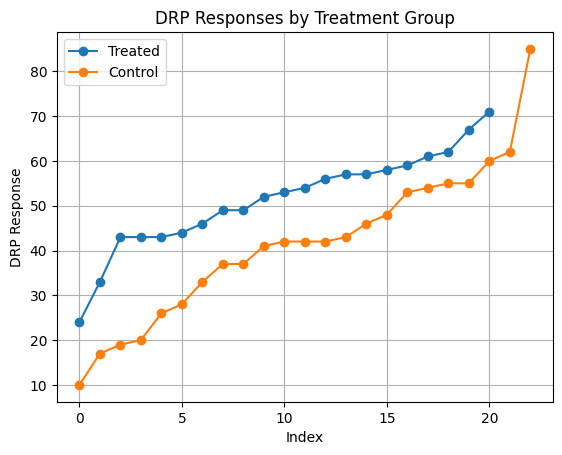

In [29]:
plt.plot(responses["Treated"], 'o-', label="Treated")
plt.plot(responses["Control"], 'o-', label="Control")
plt.legend(); plt.grid();
plt.title("DRP Responses by Treatment Group")
plt.ylabel("DRP Response")
plt.xlabel("Index");

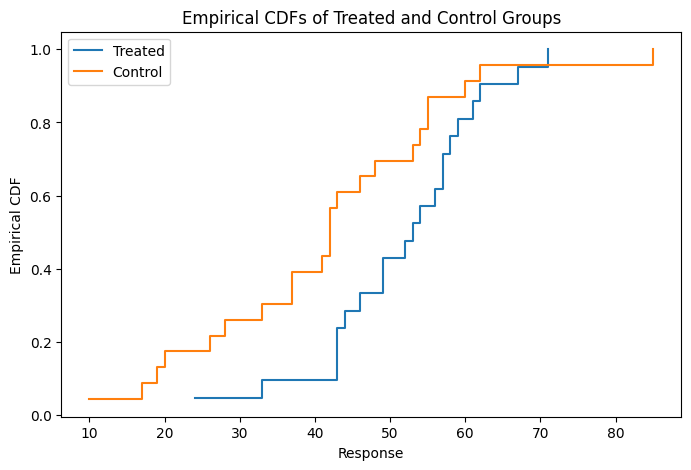

In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

# Data must be sorted to use ECDF
responses["Treated"] = sorted(responses["Treated"])
responses["Control"] = sorted(responses["Control"])

ecdf_treated = ECDF(responses["Treated"])
ecdf_control = ECDF(responses["Control"])

# ecdf_treated(x) returns  CDF(x) for the treated group
# ecdf_control(x) returns  CDF(x) for the control group

plt.figure(figsize=(8, 5))
plt.step(responses["Treated"], ecdf_treated(responses["Treated"]), label="Treated", where='post')
plt.step(responses["Control"], ecdf_control(responses["Control"]), label="Control", where='post')
plt.xlabel("Response")
plt.ylabel("Empirical CDF")
plt.legend()
plt.title("Empirical CDFs of Treated and Control Groups")
plt.show()

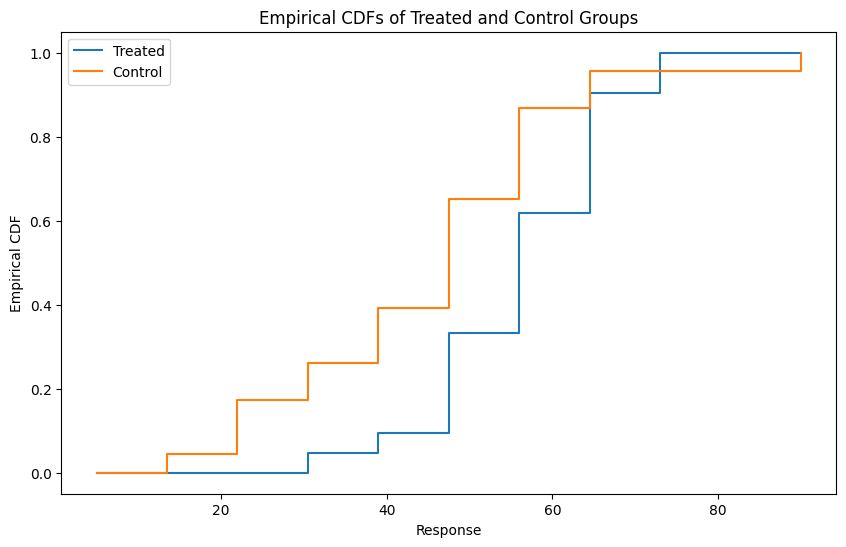

In [21]:
res = np.linspace(5, 90, 11)
plt.figure(figsize=(10, 6))
plt.step(res, ecdf_treated(res), label="Treated", where='post')
plt.step(res, ecdf_control(res), label="Control", where='post')
plt.xlabel("Response")
plt.ylabel("Empirical CDF")
plt.legend()
plt.title("Empirical CDFs of Treated and Control Groups")
plt.show()

In [31]:
np.std(responses["Treated"]), np.std(responses["Control"])

(np.float64(10.742080350166495), np.float64(16.771791963623848))

In [ ]:
# Stan model for comparing means of two groups
stan_code = """
data {
    int<lower=0> N1;         // number of treated samples
    int<lower=0> N2;         // number of control samples
    vector[N1] y1;           // treated responses
    vector[N2] y2;           // control responses
}
parameters {
    real mu1;                // mean of treated
    real mu2;                // mean of control
    real<lower=0> sigma1;    // std dev of treated
    real<lower=0> sigma2;    // std dev of control
}
model {
    mu1 ~ normal(0, 100);
    mu2 ~ normal(0, 100);
    sigma1 ~ exponential(.1);
    sigma2 ~ exponential(.1);
    y1 ~ normal(mu1, sigma1);
    y2 ~ normal(mu2, sigma2);
}
generated quantities {
    real diff_means = mu1 - mu2;
}
"""

# Save Stan model to file
stan_file = "compare_means.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

# Prepare data for Stan
stan_data = {
    "N1": len(responses["Treated"]),
    "N2": len(responses["Control"]),
    "y1": np.array(responses["Treated"]),
    "y2": np.array(responses["Control"])
}

# Compile and sample using cmdstanpy
model = cmdstanpy.CmdStanModel(stan_file=stan_file)
fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, iter_warmup=500, seed=42)

# Extract posterior samples
posterior = fit.draws_pd()
print(posterior[["mu1", "mu2", "diff_means"]].describe())